<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21e_10kGNAD_huggingface_lr_find.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding a Good Learning Rate for pre-trained HuggingFace Transformer Models

References
* Leslie N. Smith: [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)
* Sylvain Gugger: [The 1cycle policy](https://sgugger.github.io/the-1cycle-policy.html)
* FastAI `lr_find`
* ktrain `lr_find` ([1](https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb#STEP-2-[Optional]:-Estimate-a-Good-Learning-Rate), [2](https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-02-tuning-learning-rates.ipynb#A-Learning-Rate-Finder), [3](https://github.com/amaiya/ktrain/blob/master/ktrain/lroptimize/lrfinder.py))
* PyTorch Lightning `lr_find` ([1](https://pytorch-lightning.readthedocs.io/en/stable/advanced/lr_finder.html), [2](https://pytorch-lightning.readthedocs.io/en/stable/_modules/pytorch_lightning/tuner/lr_finder.html#lr_find))
* [Automated Learning Rate Suggester](https://forums.fast.ai/t/automated-learning-rate-suggester/44199) (fastAI forum)

## Prerequisites

In [69]:
checkpoint = "distilbert-base-german-cased"
# checkpoint = "deepset/gbert-base"
# checkpoint = "deepset/gelectra-base"

### Check GPU

In [70]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jan  5 16:36:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |  14957MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install Packages

In [71]:
%%time
!pip install -q -U transformers datasets >/dev/null

# check installed version
!pip freeze | grep transformers  # transformers==4.15.0
!pip freeze | grep "torch "      # torch==1.10.0+cu111


transformers==4.15.0
torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
CPU times: user 43 ms, sys: 116 ms, total: 159 ms
Wall time: 4.48 s


In [72]:
from transformers import logging

# hide progress bar when downloading tokenizer and model (a workaround!)
logging.get_verbosity = lambda : logging.NOTSET

### Load Dataset

In [73]:
from datasets import load_dataset

data = load_dataset("gnad10")
label_names = data["train"].features["label"].names

Using custom data configuration default
Reusing dataset gnad10 (/root/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881)


  0%|          | 0/2 [00:00<?, ?it/s]

## Data Preprocessing

* Loading the same Tokenizer that was used with the pretrained model.
* Define function to tokenize the text (with truncation to max input length of model.
* Run the tokenization

In [74]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_data = data.map(preprocess_function, batched=True).remove_columns("text")

Loading cached processed dataset at /root/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881/cache-5d66d7a004b32c63.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

### Use Dynamic Padding

Apply panding only on longest text in batch - this is more efficient than applying padding on the whole dataset.

In [75]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Model Setup

In [76]:
from transformers.utils.notebook import NotebookProgressCallback, NotebookProgressBar

# https://github.com/huggingface/transformers/blob/05fa1a7ac17bb7aa07b9e0c1e138ecb31a28bbfe/src/transformers/trainer_callback.py#L160

class NoTableProgressCallback(NotebookProgressCallback):
    """Progress Callback that does not print log values in a table"""

    class NoTableProgressBar(NotebookProgressBar):
        def __init__(self, total: int):
            super().__init__(total)
        def write_line(self, values):
            pass  # don't add values to table

    def on_train_begin(self, args, state, control, **kwargs):
        super().on_train_begin(args, state, control, **kwargs)
        self.training_tracker = self.NoTableProgressBar(state.max_steps)

## Find best Learning Rate

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import Trainer, TrainingArguments
from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers.optimization import AdamW
from torch.optim.lr_scheduler import ExponentialLR

# We want to include the label names and save them together with the model.
# The only way to do this is to create a Config and put them in. 
def model_init():
    """A function that instantiates the model to be used."""

    config = AutoConfig.from_pretrained(
        checkpoint,
        num_labels=len(label_names),
        id2label={i: label for i, label in enumerate(label_names)},
        label2id={label: i for i, label in enumerate(label_names)},
        )

    return AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

def lr_find(bs: int, weight_decay=0.0, min_lr=1e-7, max_lr=1e-2, steps=100, gradient_accumulation_steps=1) -> pd.Series:

    lr_mult = (max_lr / min_lr) ** (1 / steps)

    model = model_init()
    optimizer = AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    lr_scheduler = ExponentialLR(optimizer, lr_mult, last_epoch=-1)

    # https://github.com/huggingface/transformers/blob/v4.15.0/src/transformers/training_args.py#L73
    training_args = TrainingArguments(
        output_dir="/tmp",
        report_to=[],
        log_level="error",
        disable_tqdm=False,

        logging_steps=1,  # log train loss in every step
        gradient_accumulation_steps=gradient_accumulation_steps,

        # hyperparameters
        max_steps=steps,
        per_device_train_batch_size=bs,
    )

    # https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data["train"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        optimizers=(optimizer, lr_scheduler)
    )

    # replace default notebook callback
    trainer.remove_callback(NotebookProgressCallback)
    trainer.add_callback(NoTableProgressCallback)

    trainer.train()

    loss_s = pd.DataFrame(trainer.state.log_history[:-1]).set_index("learning_rate").loss

    smoothed_loss_s, suggested_lr = suggest_lr(loss_s)

    return smoothed_loss_s, suggested_lr

# from fastai - https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate

def suggest_lr(loss_s: pd.Series, beta=0.98) -> (pd.Series, int):
    avg_loss = 0.0
    smoothed = []

    for i, loss in enumerate(loss_s):
        i+=1
        avg_loss = beta * avg_loss + (1-beta) * loss
        smoothed_loss = avg_loss / (1 - beta**i)
        smoothed.append(smoothed_loss)


    offset = 10  # ignore first values
    min_grad = np.gradient(smoothed)[offset:].argmin() + offset

    return pd.Series(smoothed, index=loss_s.index), min_grad

## Find best learning rate

In [156]:
bs=32

loss_s, suggested_lr = lr_find(bs=bs, weight_decay=0.0, steps=200)

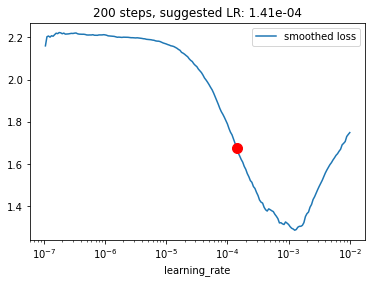

In [157]:
loss_s.plot(label="smoothed train loss")
plt.plot(loss_s.index[suggested_lr], loss_s.iloc[suggested_lr], markersize=10, marker="o", color="red")
plt.xscale("log")
plt.legend()
plt.title(f"200 steps, suggested LR: {loss_s.index[suggested_lr]:.2e}");

In [160]:
epoch_steps = tokenized_data["train"].num_rows // bs
loss_s, suggested_lr = lr_find(bs=bs, weight_decay=0.0, steps=epoch_steps)

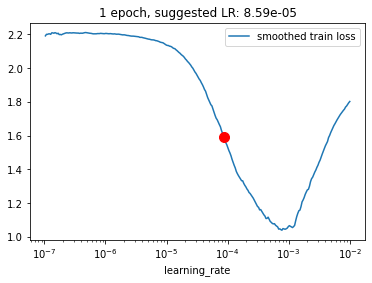

In [162]:
loss_s.plot(label="smoothed train loss")
plt.plot(loss_s.index[suggested_lr], loss_s.iloc[suggested_lr], markersize=10, marker="o", color="red")
plt.xscale("log")
plt.legend()
plt.title(f"1 epoch, suggested LR: {loss_s.index[suggested_lr]:.2e}");

In [151]:
epoch_steps = 2 * tokenized_data["train"].num_rows // bs
loss_s, suggested_lr = lr_find(bs=bs, weight_decay=0.0, steps=epoch_steps)

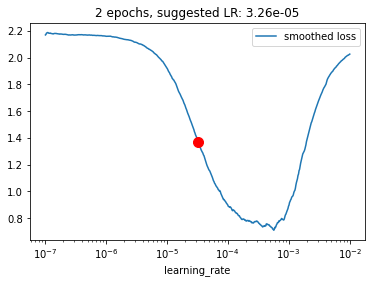

In [155]:
loss_s.plot(label="smoothed train loss")
plt.plot(loss_s.index[suggested_lr], loss_s.iloc[suggested_lr], markersize=10, marker="o", color="red")
plt.xscale("log")
plt.legend()
plt.title(f"2 epochs, suggested LR: {loss_s.index[suggested_lr]:.2e}");

In [158]:
epoch_steps = 3 * tokenized_data["train"].num_rows // bs
loss_s, suggested_lr = lr_find(bs=bs, weight_decay=0.0, steps=epoch_steps)

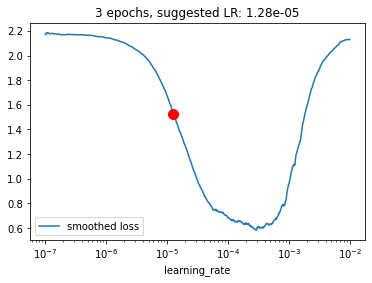

In [159]:
loss_s.plot(label="smoothed train loss")
plt.plot(loss_s.index[suggested_lr], loss_s.iloc[suggested_lr], markersize=10, marker="o", color="red")
plt.xscale("log")
plt.legend()
plt.title(f"3 epochs, suggested LR: {loss_s.index[suggested_lr]:.2e}");

In [163]:
epoch_steps = 5 * tokenized_data["train"].num_rows // bs
loss_s, suggested_lr = lr_find(bs=bs, weight_decay=0.0, steps=epoch_steps)

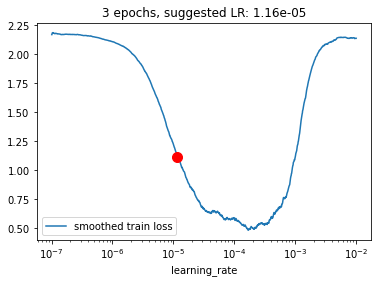

In [164]:
loss_s.plot(label="smoothed train loss")
plt.plot(loss_s.index[suggested_lr], loss_s.iloc[suggested_lr], markersize=10, marker="o", color="red")
plt.xscale("log")
plt.legend()
plt.title(f"3 epochs, suggested LR: {loss_s.index[suggested_lr]:.2e}");

## Compare Loss Curves for different Hyperparameters

* batch size
* weight decay

In [117]:
%%time

steps_l = [50, 100, 200]
wd_l = [0.0, 0.001, 0.01]
batch_sizes = [32, 16, 8]  # must be multiples

grad_steps_bs = [max(batch_sizes) // bs for bs in batch_sizes]

losses = {}

for steps in steps_l:
    for wd in wd_l:
        for bs, grad_steps in zip(batch_sizes, grad_steps_bs):
            loss_s, _ = lr_find(bs=bs, weight_decay=wd, steps=steps, gradient_accumulation_steps=grad_steps)
            losses[(steps, wd, bs)] = loss_s

CPU times: user 47min 21s, sys: 7.99 s, total: 47min 29s
Wall time: 47min 46s


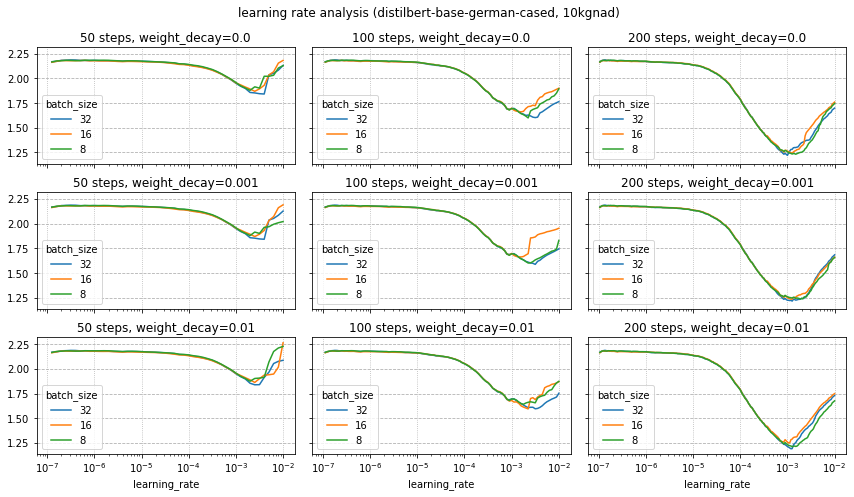

In [141]:
fig, axs = plt.subplots(len(steps_l), len(wd_l), figsize=(12,7), sharex=True, sharey=True)

for i, steps in enumerate(steps_l):
    for j, wd in enumerate(wd_l):
        ax = axs[j,i]
        for bs in batch_sizes:
            s = losses[(steps, wd, bs)]
            s.plot(ax=ax, label=bs)
        ax.set_title(f"{steps} steps, weight_decay={wd}")
        ax.set_xscale("log")
        ax.grid(axis='y', linestyle='--', zorder=1)
        ax.grid(axis='x', linestyle=':', zorder=1)
        ax.legend(title="batch_size", loc='lower left');

fig.tight_layout()
fig.suptitle(f"learning rate analysis ({checkpoint}, 10kgnad)", size=12)
fig.subplots_adjust(top=0.9)

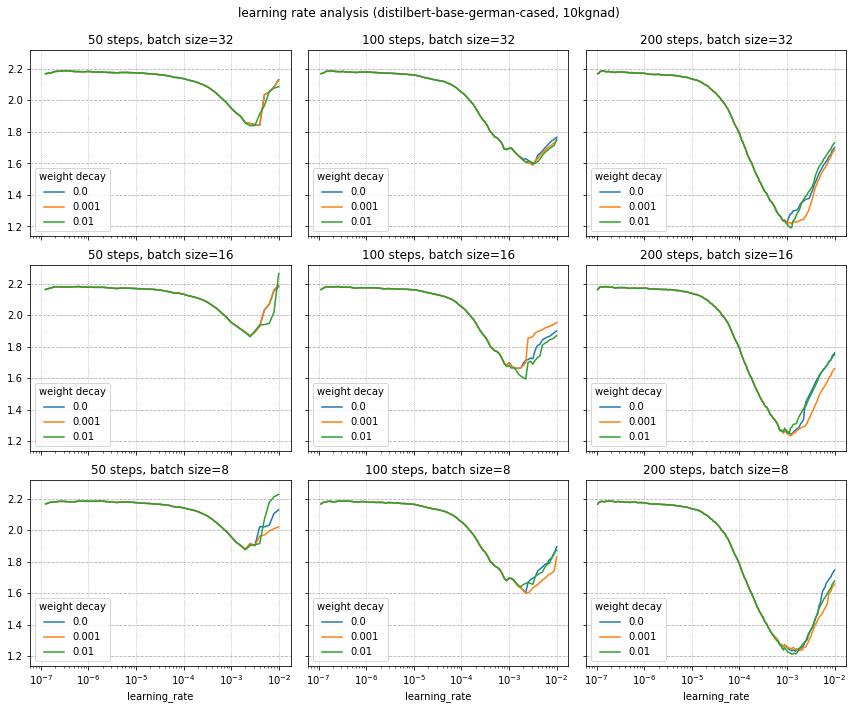

In [138]:
fig, axs = plt.subplots(len(steps_l), len(wd_l), figsize=(12,10), sharex=True, sharey=True)

for i, steps in enumerate(steps_l):
    for j, bs in enumerate(batch_sizes):
        ax = axs[j,i]
        for wd in wd_l:
            s = losses[(steps, wd, bs)]
            s.plot(ax=ax, label=wd)
        ax.set_title(f"{steps} steps, batch size={bs}")
        ax.set_xscale("log")
        ax.grid(axis='y', linestyle='--', zorder=1)
        ax.grid(axis='x', linestyle=':', zorder=1)
        ax.legend(title="weight decay", loc='lower left');

fig.tight_layout()
fig.suptitle(f"learning rate analysis ({checkpoint}, 10kgnad)", size=12)
fig.subplots_adjust(top=0.92)

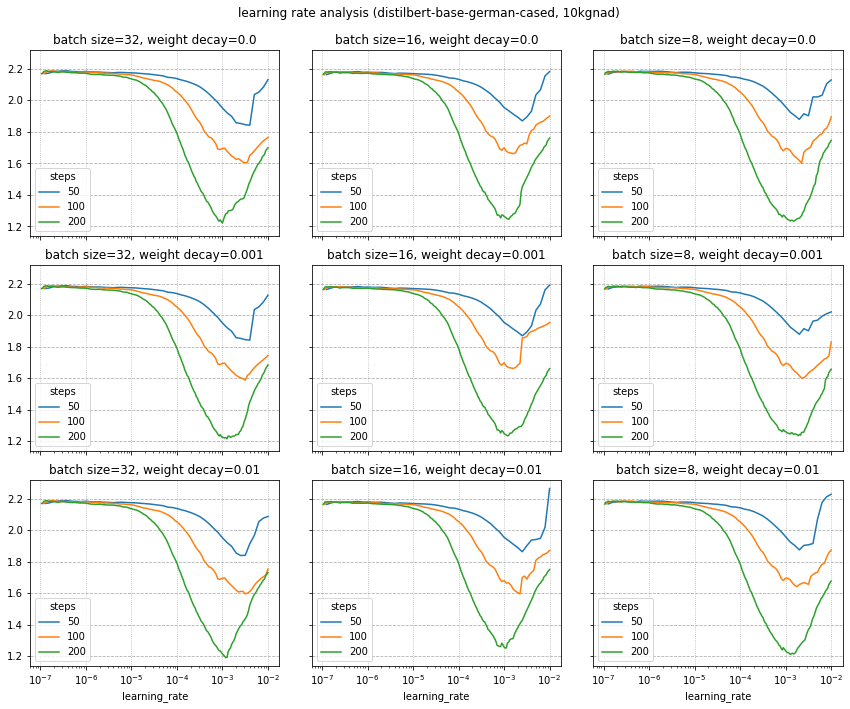

In [139]:
fig, axs = plt.subplots(len(steps_l), len(wd_l), figsize=(12,10), sharex=True, sharey=True)

for i, bs in enumerate(batch_sizes):
    for j, wd in enumerate(wd_l):
        ax = axs[j,i]
        for steps in steps_l:
            s = losses[(steps, wd, bs)]
            s.plot(ax=ax, label=steps)
        ax.set_title(f"batch size={bs}, weight decay={wd}")
        ax.set_xscale("log")
        ax.grid(axis='y', linestyle='--', zorder=1)
        ax.grid(axis='x', linestyle=':', zorder=1)
        ax.legend(title="steps", loc='lower left');

fig.tight_layout()
fig.suptitle(f"learning rate analysis ({checkpoint}, 10kgnad)", size=12)
fig.subplots_adjust(top=0.92)